<a href="https://colab.research.google.com/github/mohamedashraf111999/ML/blob/master/Image_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Improting pytoch, domain libraries

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

#checking torch vision

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Getting the dataset

import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "pizza_sreak_sushi"

if image_path.is_dir():
  print(f"{image_path} dir is already exist.... skipping download. ")
else:
  print(f"{image_path} does not exist, creating one....")
  image_path.mkdir(parents = True, exist_ok=True)


# Downloading Datasets
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading Pizza, steak, sushi data....")
  f.write(request.content)


# UnZip Dataset
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_sreak_sushi does not exist, creating one....
downloading Pizza, steak, sushi data....
Unzipping pizza, steak, sushi data...


In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_sreak_sushi/train'),
 PosixPath('data/pizza_sreak_sushi/test'))

In [5]:
# 1. Perpare the transforms

from torchvision import transforms
train_simple_transforms = transforms.Compose(
    {
        transforms.Resize((64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins = 31),
        transforms.ToTensor(),

    }
)
test_simple_transforms = transforms.Compose(
    {
        transforms.Resize((64, 64)),
        transforms.ToTensor(),

    }
)

In [6]:
# Loading image using torchvision.datasets.ImageFolder

from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root= train_dir,
    transform= train_simple_transforms,
)
test_data_simple = datasets.ImageFolder(
    root= test_dir,
    transform= test_simple_transforms
)

class_names = train_data_simple.classes

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_sreak_sushi/train
     StandardTransform
 Transform: Compose(
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_sreak_sushi/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
            ))

In [7]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 5
NUM_WORKERS = os.cpu_count()
simple_train_dataloader = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

simple_test_dataloader = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)
simple_train_dataloader, simple_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fcf68f74af0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcf6bfc35e0>)

In [8]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=train_simple_transforms)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_simple_transforms)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
simple_train_dataloader = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

simple_test_dataloader = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 32 and 2 workers.


In [9]:
# Build TinyVGG16

from torch import nn

class TinyVGG16(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels= hidden_units,
            kernel_size= 3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels= hidden_units,
            kernel_size= 3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels= hidden_units,
            kernel_size= 3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels= hidden_units,
            kernel_size= 3,
            padding=0,
            stride=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*13*13,
                  out_features= output_shape)
    )

  def forward(self, x):
    x= self.conv_layer_1(x)
    #print(x.shape)
    x= self.conv_layer_2(x)
    #print(x.shape)
    x= self.classifier_layer(x)
    return x

In [10]:
def model_train(model: torch.nn.Module, # Model parameter
                dataloader: torch.utils.data.DataLoader, #Data prameter
                loss_fn: torch.nn.Module, # Loss_fn Parameter
                optimizer: torch.optim.Optimizer, # Optimizer Parameter
                device: device): #Device Parameter

  #Go in training Model using .train()
  model.train()

  #Intialize loss, acc for all training
  train_loss, train_acc = 0, 0


  #For loop to loop through the batches
  for batch, (X, y) in enumerate(dataloader):

    #Send the data to targeted Device
    X, y = X.to(device), y.to(device)

    # Do the forward Pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    #Accumilate the loss
    train_loss += loss.item()
    # Optim Zero Grad
    optimizer.zero_grad()
    # Do the forward Pass
    loss.backward()
    # Optim step
    optimizer.step()
    # Calculate the matrix
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim =1)

    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [11]:
from torch.autograd.grad_mode import inference_mode
def model_test(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device = device):

  # Go in test Model using .eval() and with inference_mode()
  model.eval()
  with inference_mode():

    test_loss, test_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)

      test_loss += loss.item()

      y_pred_labels = torch.argmax(torch.softmax(y_pred, dim = 1), dim =1)

      test_acc += (y_pred_labels==y).sum().item()/len(y_pred)


  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc

In [12]:
from tqdm.auto import tqdm



def model_train_test(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               train_func = None,
               test_func = None,
               epochs: int = 3
               ):

  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  epochs = epochs
  for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}\n---------")
      train_loss, train_acc = model_train(dataloader=train_dataloader,
          model=model,
          loss_fn=loss_fn,
          optimizer=optimizer,
          device = device
      )
      test_loss, test_acc = model_test(dataloader=test_dataloader,
          model=model,
          loss_fn=loss_fn,
          device = device
      )

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )


      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  return results

In [13]:
from timeit import default_timer as timer
torch.manual_seed(42)
NUM_EPOCHS = 20

model_0 = TinyVGG16(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)


start_time = timer()


model_0_results = model_train_test(model= model_0,
                        train_dataloader=simple_train_dataloader,
                        test_dataloader=simple_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 1 | train_loss: 1.1071 | train_acc: 0.2891 | test_loss: 1.0993 | test_acc: 0.2083
Epoch: 1
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 2 | train_loss: 1.1020 | train_acc: 0.3047 | test_loss: 1.0699 | test_acc: 0.5417
Epoch: 2
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 3 | train_loss: 1.0910 | train_acc: 0.3281 | test_loss: 1.0818 | test_acc: 0.5227
Epoch: 3
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 4 | train_loss: 1.0895 | train_acc: 0.3320 | test_loss: 1.0594 | test_acc: 0.6042
Epoch: 4
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 5 | train_loss: 1.0789 | train_acc: 0.3672 | test_loss: 1.0627 | test_acc: 0.4924
Epoch: 5
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 6 | train_loss: 1.0411 | train_acc: 0.4219 | test_loss: 1.0052 | test_acc: 0.5322
Epoch: 6
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 7 | train_loss: 1.0791 | train_acc: 0.3750 | test_loss: 0.9658 | test_acc: 0.5833
Epoch: 7
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 8 | train_loss: 1.0774 | train_acc: 0.4062 | test_loss: 1.0075 | test_acc: 0.4640
Epoch: 8
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 9 | train_loss: 1.0167 | train_acc: 0.5156 | test_loss: 1.0864 | test_acc: 0.3116
Epoch: 9
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 10 | train_loss: 1.0741 | train_acc: 0.4531 | test_loss: 1.1083 | test_acc: 0.2917
Epoch: 10
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 11 | train_loss: 0.9620 | train_acc: 0.6094 | test_loss: 0.9733 | test_acc: 0.5142
Epoch: 11
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 12 | train_loss: 1.0037 | train_acc: 0.4180 | test_loss: 0.9380 | test_acc: 0.5644
Epoch: 12
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 13 | train_loss: 0.8831 | train_acc: 0.6094 | test_loss: 1.0077 | test_acc: 0.3826
Epoch: 13
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 14 | train_loss: 1.0066 | train_acc: 0.4531 | test_loss: 1.0140 | test_acc: 0.3722
Epoch: 14
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 15 | train_loss: 0.9284 | train_acc: 0.6211 | test_loss: 0.9594 | test_acc: 0.4223
Epoch: 15
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 16 | train_loss: 0.8656 | train_acc: 0.6445 | test_loss: 0.9524 | test_acc: 0.4214
Epoch: 16
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 17 | train_loss: 0.9343 | train_acc: 0.5000 | test_loss: 0.9896 | test_acc: 0.4337
Epoch: 17
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 18 | train_loss: 0.9063 | train_acc: 0.6367 | test_loss: 1.0807 | test_acc: 0.3617
Epoch: 18
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 19 | train_loss: 0.9420 | train_acc: 0.6055 | test_loss: 0.9888 | test_acc: 0.5038
Epoch: 19
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: 20 | train_loss: 0.8217 | train_acc: 0.6641 | test_loss: 1.0292 | test_acc: 0.4129
Total training time: 84.461 seconds


In [14]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):

  loss= model_0_results['train_loss']
  test_loss = model_0_results['test_loss']

  acc = model_0_results['train_acc']
  test_acc = model_0_results['test_acc']


  epochs = range(len(model_0_results['train_acc']))

  plt.figure(figsize=(15, 7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Acc")
  plt.xlabel("Epochs")
  plt.legend()

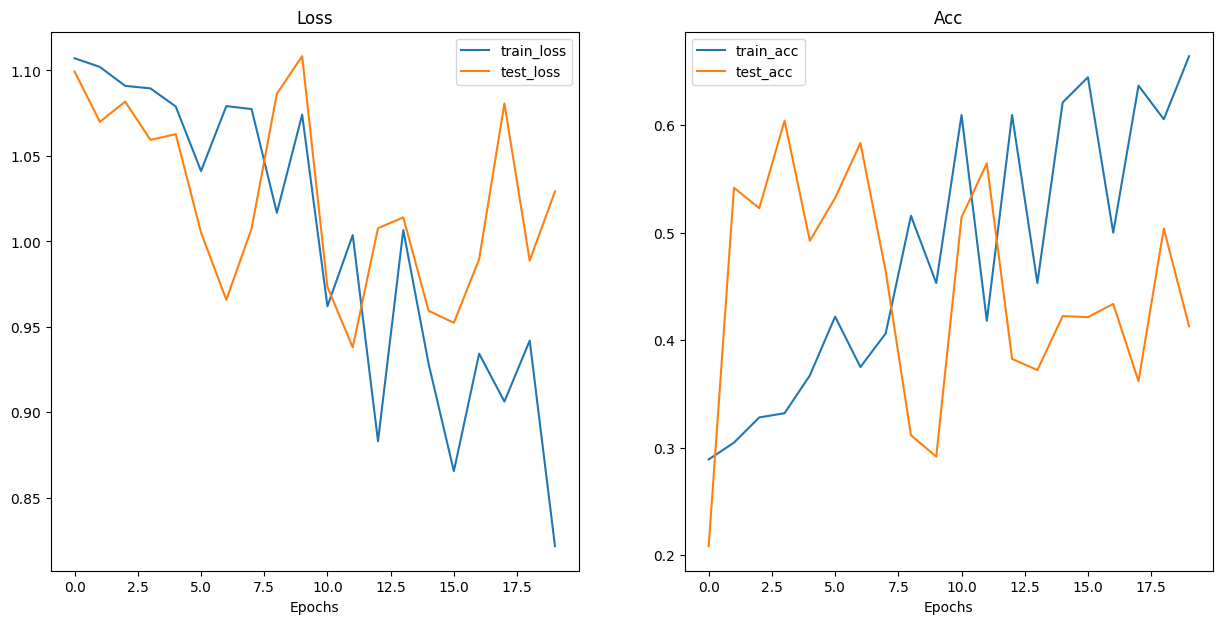

In [15]:
plot_loss_curves(model_0_results)

In [26]:
import requests

img_path = data_path / "Cheese-Pizza-Feature.jpg"

if not img_path.is_file():
  with open(img_path, "wb") as f:
    request = requests.get("https://preppykitchen.com/wp-content/uploads/2021/10/Cheese-Pizza-Feature.jpg")
    print("Downlo0ading the Image....")
    f.write(request.content)
else:
  print(f"{img_path} already exist, skipping download")

data/Cheese-Pizza-Feature.jpg already exist, skipping download


In [27]:
img_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [31]:
print(img_path)

data/Cheese-Pizza-Feature.jpg


In [43]:
from PIL import Image
import numpy as np
def make_prediction(img_path: str):

  img = Image.open(img_path)
  np_img = np.array(img).astype(float)
  print(f"Image Shape : {np_img.shape}")
  transforemd_img = img_transform(img)
  print(f"Transformed Image Shape : {transforemd_img.shape}")
  print(f"Image after reshaping \n: {transforemd_img}\n\n\n")

  # Showing Image
  plt.imshow(transforemd_img.permute(1, 2, 0))
  plt.axis("off")
  model_0.eval()
  with torch.inference_mode():
    img_logits = model_0(transforemd_img.unsqueeze(0).to(device))

  image_pred_probs = torch.softmax(img_logits, dim=1)
  print(f"Prediction probabilities: {image_pred_probs}")
  image_pred_label = torch.argmax(image_pred_probs, dim=1)
  image_pred_class = class_names[image_pred_label.cpu()] # put pred label to CPU, otherwise will error
  return image_pred_class

Image Shape : (1700, 1200, 3)
Transformed Image Shape : torch.Size([3, 64, 64])
Image after reshaping 
: tensor([[[0.8824, 0.8863, 0.8980,  ..., 0.9922, 0.9922, 0.9882],
         [0.8745, 0.8863, 0.8902,  ..., 0.9843, 0.9843, 0.9882],
         [0.8706, 0.8706, 0.8706,  ..., 0.9961, 0.9882, 0.9843],
         ...,
         [0.4353, 0.4353, 0.3961,  ..., 0.6157, 0.6667, 0.7333],
         [0.4275, 0.4000, 0.3843,  ..., 0.5843, 0.6745, 0.7255],
         [0.3804, 0.3922, 0.4039,  ..., 0.6392, 0.7137, 0.7529]],

        [[0.7059, 0.7176, 0.7137,  ..., 0.9882, 0.9922, 0.9882],
         [0.7059, 0.6980, 0.6941,  ..., 0.9686, 0.9725, 0.9804],
         [0.7059, 0.6941, 0.6824,  ..., 0.9765, 0.9725, 0.9686],
         ...,
         [0.2706, 0.2784, 0.2588,  ..., 0.1451, 0.3608, 0.6627],
         [0.2784, 0.2627, 0.2510,  ..., 0.2471, 0.4863, 0.6627],
         [0.2471, 0.2588, 0.2667,  ..., 0.5569, 0.6510, 0.7020]],

        [[0.7255, 0.7255, 0.7216,  ..., 0.9804, 0.9922, 0.9882],
         [0.7216, 

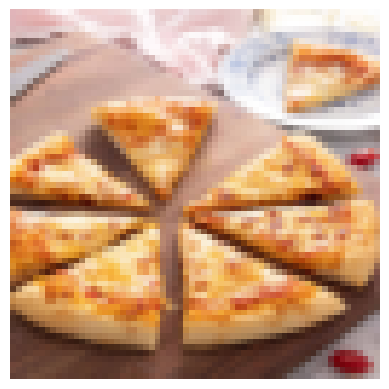

In [42]:

img_path = data_path / "Cheese-Pizza-Feature.jpg"
label = make_prediction(img_path=img_path)
print(f"Model Predicted: {label}")